# Gaussian Telescope: Optical Analysis

### An example of the 'gaussopt' package

**Description:** This notebook shows an example of how to use the 'gaussopt' module to evaluate a system. Benefits of using the 'gaussopt' module:

**1.** You can do frequency sweeps: you are given results over a range of frequencies, instead of just one single frequency.

**2.** You can do distance sweeps: You are able to sweep any variable you like, and see how that affects coupling/tapers/etc.

In this example, I set up a Gaussian beam telescope (GBT) that is roughly based on my own experimental setup. All of the mirrors have focal lengths of 160 mm. GBTs are theoretically frequency independent; however, the beam waist offset from the horn apertures is not. This can affect coupling as we'll see in this example.

Author: John Garrett

In [1]:
import gaussopt as go
import numpy as np
import matplotlib.pyplot as plt 
from scipy.constants import c as C0  # speed of light
%matplotlib inline

GHz = 1e9

### 1) Define frequency range

Note that I include a center frequency. This is the frequency that I am designing the optical system for. I am choosing to work in millimeters. This module can also work in meters -- just be consistent.

In [2]:
start = 180 * GHz
stop = 280 * GHz
center = 230 * GHz
n_points = 101

frequency = np.linspace(start, stop, n_points) #Hz
index_center = np.abs(frequency - center).argmin()

wavelength = C0 / frequency * 1000 #mm

### 2) Calculate input beam parameters from Tx horn

In [3]:
slant_length = 22.64
aperture_radius = 3.6
horn_factor = 0.59

q_in, waist_in, z_offset_in = go.horn(slant_length, aperture_radius, horn_factor, wavelength)

print "Tx horn waist:    \t %f mm \t at f = 230 GHz" % (waist_in[index_center])
print "Tx horn z offset: \t %f mm \t at f = 230 GHz" % (z_offset_in[index_center])

Tx horn waist:    	 1.914630 mm 	 at f = 230 GHz
Tx horn z offset: 	 4.243422 mm 	 at f = 230 GHz


### 3) Define optical components

Since the beam waist is actually behind the horn aperture, the distance between the horn and the first mirror must be equal to the focal length minus the beam offset.

In [4]:
reduced_distance = 160 - z_offset_in[index_center]
print "Distance b/w horn and mirror = {0:.2f} mm".format(reduced_distance)

air_160_reduced = go.freespace(160 - z_offset_in[index_center])
air_160         = go.freespace(160)
mirror_f160     = go.mirror(160)

Distance b/w horn and mirror = 155.76 mm


### 4) Build overall system matrix

This must be done in reverse order! Although that doesn't matter in this case...

In [5]:
system = air_160_reduced * mirror_f160 * air_160 * air_160 * mirror_f160 * air_160_reduced

### 5) Calculate output beam parameters

In [6]:
q_out, waist_out, R_out = go.beam_output(system, q_in, wavelength)

### 6) Calculate coupling to Rx horn

In [7]:
coupling = go.coupling(q_out, slant_length, aperture_radius, horn_factor, wavelength)
print "Coupling = {0:.2f} %\tat f = 230 GHz".format(coupling[index_center] * 100)

Coupling = 100.00 %	at f = 230 GHz


### 7) Plot coupling

As seen here, the coupling isn't always 100%!

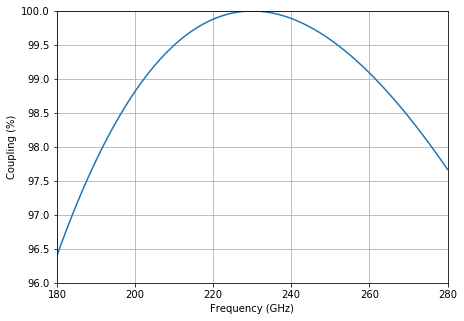

In [8]:
plt.figure(figsize=(7,5))
plt.plot(frequency / 1e9, coupling * 100)
plt.xlabel('Frequency (GHz)')
plt.ylabel('Coupling (%)')
plt.grid(True)
plt.ylim([96, 100])
plt.xlim([180, 280])
plt.show()

### 8) Analyze edge taper at beam splitter

Note how frequency dependent this is!

Beam waist at beamsplitter = 34.67 mm  at f = 230 GHz


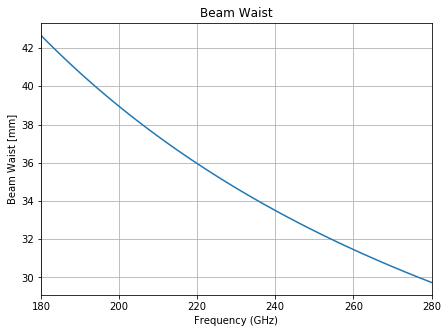

Beam-splitter radius = 60.00 mm
Edge taper = 26.01 dB  at 230 GHz


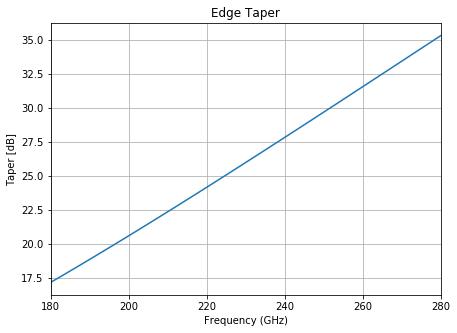

In [9]:
# The beam splitter is inbetween the two mirrors
# Therefore, build the system matrix up to this point
system_bs = air_160 * mirror_f160 * air_160_reduced
_, waist_at_bs, _ = go.beam_output(system_bs, q_in, wavelength)
print "Beam waist at beamsplitter = {0:.2f} mm  at f = 230 GHz".format(waist_at_bs[index_center])

plt.figure(figsize=(7,5))
plt.plot(frequency / 1e9, waist_at_bs)
plt.xlabel('Frequency (GHz)')
plt.ylabel('Beam Waist [mm]')
plt.grid(True)
# plt.ylim([96, 100])
plt.xlim([180, 280])
plt.title('Beam Waist')
plt.show()

beamsplitter_aperture_radius = 60.  # in mm
print "Beam-splitter radius = {0:.2f} mm".format(beamsplitter_aperture_radius)

# Edge taper is returned in dB
taper = go.edge_taper(waist_at_bs, beamsplitter_aperture_radius)
print "Edge taper = {0:.2f} dB  at 230 GHz".format(taper[index_center])

plt.figure(figsize=(7,5))
plt.plot(frequency / 1e9, taper)
plt.xlabel('Frequency (GHz)')
plt.ylabel('Taper [dB]')
plt.grid(True)
plt.xlim([180, 280])
plt.title('Edge Taper')
plt.show()

### 9) Tolerance analysis

What happens if the receiving horn is out of place?

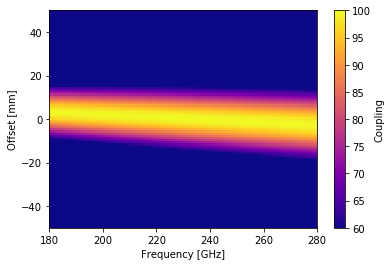

In [10]:
offset = np.linspace(-50, 50, 101)  # plus or minus 1 cm

coupling_results = np.zeros((np.alen(offset), np.alen(frequency)))

for ind, d in enumerate(offset):
    air_160_red_and_offset = go.freespace(160 - z_offset_in[index_center] + d)
    system = air_160_red_and_offset * mirror_f160 * air_160 * air_160 * mirror_f160 * air_160_reduced
    q_out, waist_out, R_out = go.beam_output(system, q_in, wavelength)
    coupling_results[ind] = go.coupling(q_out, slant_length, aperture_radius, horn_factor, wavelength)*100
    
plt.pcolor(frequency / GHz, offset, coupling_results, cmap='plasma', vmin=60, vmax=100)
plt.xlabel('Frequency [GHz]')
plt.ylabel('Offset [mm]')
# plt.zlim([0, 100])
cb = plt.colorbar()
cb.set_label('Coupling')

Or if they're both off

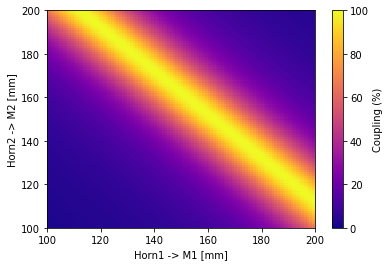

In [12]:
frequency = np.array([230 * GHz])
index_center = np.abs(frequency - center).argmin()
wavelength = C0 / frequency * 1000

q_in, waist_in, z_offset_in = go.horn(slant_length, aperture_radius, horn_factor, wavelength)

distance1 = np.linspace(100, 200, 101)  # plus or minus 1 cm
distance2 = np.linspace(100, 200, 101)  # plus or minus 1 cm

coupling_results = np.zeros((np.alen(distance1), np.alen(distance2)))

for ind1, d1 in enumerate(distance1):
    for ind2, d2 in enumerate(distance2):
        
        air_160_red_and_offset1 = go.freespace(d1)
        air_160_red_and_offset2 = go.freespace(d2)
        
        system = air_160_red_and_offset1 * mirror_f160 * air_160 * air_160 * mirror_f160 * air_160_red_and_offset2
        q_out, waist_out, R_out = go.beam_output(system, q_in, wavelength)
        
        coupling_results[ind1, ind2] = go.coupling(q_out, slant_length, aperture_radius, horn_factor, wavelength)[0]*100
    
plt.pcolor(distance1, distance2, coupling_results, cmap='plasma', vmin=0, vmax=100)
plt.xlabel('Horn1 -> M1 [mm]')
plt.ylabel('Horn2 -> M2 [mm]')
cb = plt.colorbar()
cb.set_label('Coupling (%)')